In [13]:
import numpy as np
data = np.load('/tmp/game_data.npy')
labels = np.load('/tmp/game_labels.npy')



In [14]:
print(data.shape)

(49996, 6, 256)


In [15]:
data = data[:,-1,:]
print (data.shape)
print(data[0])

(49996, 256)
[ 0.24148182  0.02439024  0.19507063  0.3285779   0.26        0.49238303
  0.1548292   0.          0.15809285  0.24230431  0.36585366  0.54393547
  0.41516772  0.38636364  0.48029412  0.20183201  0.24444444  0.44540769
  0.26676763  0.26829268  0.36649499  0.32117934  0.76190476  0.53982522
  0.12613522  0.          0.0740172   0.51388212  0.37777778  0.2629619   0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.          0.
  

In [16]:
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
import keras
from keras.regularizers import l2

model = Sequential()

model.add(Dense(units=500, input_dim=data.shape[1], kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dense(units=2))
model.add(Activation('softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.RMSprop(lr=0.001),
             metrics=[keras.metrics.mae, keras.metrics.categorical_accuracy])


In [17]:
print(labels.shape)

(49996, 2)


In [18]:
val_split = int(len(data) * 0.8)
train_split = int(val_split * 0.7)
print(data.shape)
x_train = data[:train_split,:]
y_train = labels[:train_split,:]
x_val = data[val_split:,:]
y_val = labels[val_split:,:]
x_test = data[train_split:val_split,:]
y_test = labels[train_split:val_split,:]


# separate into train and test
#x_train = data[:30000,:]
#y_train = labels[:30000,:]
#x_test = data[30000:,]
#y_test = labels[30000:,:]
print(y_test.shape)
print(x_train.shape)


(49996, 256)
(11999, 2)
(27997, 256)


In [19]:
model_checkpoint = keras.callbacks.ModelCheckpoint('/tmp/best_weights', monitor='val_categorical_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit(x_train, y_train, epochs=50, batch_size=100, validation_split=0.0, validation_data=(x_val, y_val), verbose=2,callbacks = [model_checkpoint])

Train on 27997 samples, validate on 10000 samples
Epoch 1/50
0s - loss: 0.9860 - mean_absolute_error: 0.4996 - categorical_accuracy: 0.5095 - val_loss: 0.6966 - val_mean_absolute_error: 0.4976 - val_categorical_accuracy: 0.5225
Epoch 2/50
0s - loss: 0.6941 - mean_absolute_error: 0.4992 - categorical_accuracy: 0.5172 - val_loss: 0.6937 - val_mean_absolute_error: 0.4989 - val_categorical_accuracy: 0.5225
Epoch 3/50
0s - loss: 0.6935 - mean_absolute_error: 0.4992 - categorical_accuracy: 0.5194 - val_loss: 0.6931 - val_mean_absolute_error: 0.4989 - val_categorical_accuracy: 0.5225
Epoch 4/50
0s - loss: 0.6933 - mean_absolute_error: 0.4991 - categorical_accuracy: 0.5194 - val_loss: 0.6931 - val_mean_absolute_error: 0.4995 - val_categorical_accuracy: 0.5225
Epoch 5/50
0s - loss: 0.6932 - mean_absolute_error: 0.4993 - categorical_accuracy: 0.5192 - val_loss: 0.6930 - val_mean_absolute_error: 0.4992 - val_categorical_accuracy: 0.5225
Epoch 6/50
0s - loss: 0.6932 - mean_absolute_error: 0.4991 -

In [20]:
model.load_weights('/tmp/best_weights')

In [21]:
# Test loss and accuracy
loss_and_metrics = model.evaluate(x_test, y_test)
print(loss_and_metrics)

10944/11999 [==========================>...] - ETA: 0s[0.69346929947647795, 0.49965840607387285, 0.51462621882424986]


dict_keys(['val_categorical_accuracy', 'categorical_accuracy', 'loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


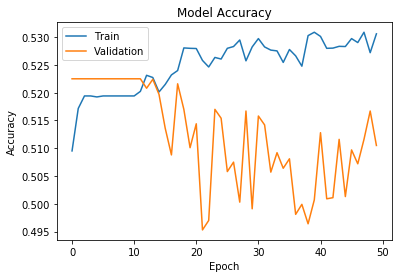

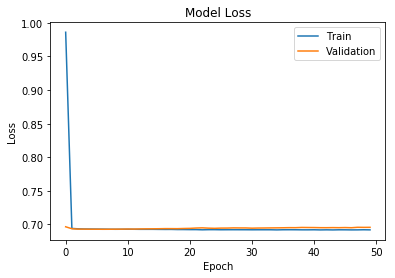

In [22]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('acc_non-expert.pdf')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'][0:])
plt.plot(history.history['val_loss'][0:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.savefig('loss_non-expert.pdf')
plt.show()

In [23]:
from sklearn.metrics import roc_auc_score
y_pred = model.predict_proba(x_test, verbose=0)
score = roc_auc_score(y_test, y_pred)
print(score)

0.501278362326


In [24]:
y_pred = model.predict_proba(x_test, verbose=0)
ind1 = y_pred[:,0] > 0.6
ind2 = y_pred[:,1] > 0.6
ind = ind1 + ind2
y_pred2 = y_pred[ind]
y_test2 = y_test[ind]
x_test2 = x_test[ind]
print(ind)
print(y_pred2.shape)
print(y_pred.shape)
score = roc_auc_score(y_test2, y_pred2)
print(score)

loss_and_metrics1 = model.evaluate(x_test, y_test, verbose=2)
loss_and_metrics = model.evaluate(x_test2, y_test2, verbose=2)
print(loss_and_metrics1)
print(loss_and_metrics)

[False False False ..., False False False]
(0, 2)
(11999, 2)


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.